In [2]:
import numpy as np
import nlopt
import pandas as pd
from math import log, exp
from multiprocessing import Pool, cpu_count
import time
import matplotlib.pyplot as plt
%matplotlib inline

# this is for individual H30

In [3]:
def rho(rbp,g,L,d):
    r = rbp*(d+2*(g/rbp)*L*(1 - exp(-d/L)))
    return(r)

In [4]:
def single_dist_obj_fun(r,x):
    d,h0,h1,h2,th = x
    r = r*(d)
    calcH0 =(18+13*r + r**2 + 36*th + 22*th**2 + 4*th**3 + r*(6*th+th**2))/((1+th)*(18+13*r+r**2+54*th + 40*th**2+8*th**3+r*(r*th+19*th+6*th**2)))
    calcH2 = (th**2*(36+14*r+r**2+36*th+6*th*r+8*th**2))/((1+th)*(18+13*r+r**2+54*th + 40*th**2+8*th**3+r*(r*th+19*th+6*th**2)))
    calcH1 = 1 - calcH0 - calcH2
    
    val = h0*log(calcH0) + h1*log(calcH1)+h2*log(calcH2)
    return(val)

In [5]:
def single_dist_multi_ind_obj_fun(r,xl):
    res = [ single_dist_obj_fun(r,xs) for xs in xl]
    res = sum(res)
    return(res)

In [61]:
def find_max_like_single_dist(args):
    d, testChr = args
    opt = nlopt.opt(nlopt.LN_NELDERMEAD,1)
    opt.set_lower_bounds([0.00000001])
    opt.set_upper_bounds([0.5])
    startPoint = [0.001]
    opt.set_max_objective(lambda x, grad: single_dist_obj_fun(x,testChr))
    res = opt.optimize(startPoint)
    return(res[0])

In [7]:
def calc_single_dist(x,rbp,g,L):
    d,h0,h1,h2,th = x
    
    r = rbp*(d+2*(g/rbp)*L*(1 - exp(-d/L)))
    
    calcH0 =(18+13*r + r**2 + 36*th + 22*th**2 + 4*th**3 + r*(6*th+th**2))/((1+th)*(18+13*r+r**2+54*th + 40*th**2+8*th**3+r*(r*th+19*th+6*th**2)))
    calcH2 = (th**2*(36+14*r+r**2+36*th+6*th*r+8*th**2))/((1+th)*(18+13*r+r**2+54*th + 40*th**2+8*th**3+r*(r*th+19*th+6*th**2)))
    calcH1 = 1 - calcH0 - calcH2
    
    val = h0*log(calcH0) + h1*log(calcH1)+h2*log(calcH2)
    return(val)

In [8]:
def single_chr_obj_fun(x_,arr):
    rbp, g, L = x_
    test = np.apply_along_axis(lambda x: calc_single_dist(x,rbp,g,L),1,arr)
    obfun = np.sum(test)
    #test = [calc_single_dist(x,rbp,g,L) for x in arr]
    #obfun = sum(test)
    return(obfun)

In [9]:
def across_chr_obj_fun(x,dfArrList,numChrs):
    
    rList = x[0:numChrs]
    gList = x[numChrs:numChrs+numChrs]
    L = x[-1]
    
    obFun = sum([single_chr_obj_fun([rs,gs,L],arr) for (rs,gs,arr) in list(zip(rList,gList,dfArrList))])
    
    return(obFun)

In [10]:
def find_max_like_single_ind(rep):
    
    numberChromsomes = 19
    dfListAuto = [x.iloc[:,[0,4,5,6,11]].to_numpy() for x in dfListAuto]

    lowerBounds = [0.0001 for x in range(numberChromsomes)]+ [0.0001 for x in range(numberChromsomes)]+[10]
    upperBounds = [0.1 for x in range(numberChromsomes)]+[0.1 for x in range(numberChromsomes)]+[2000]
    startPoints = [0.001 for x in range(numberChromsomes)]+[0.001 for x in range(numberChromsomes)]+[50]


    opt=nlopt.opt(nlopt.LN_NELDERMEAD,numberChromsomes+numberChromsomes+1)

    opt.set_lower_bounds(lowerBounds)
    opt.set_upper_bounds(upperBounds)

    opt.set_max_objective(lambda x,grad: across_chr_obj_fun(x,dfListAuto,numberChromsomes))

    res = opt.optimize(startPoints)
    return(res)

In [11]:
def find_max_like_group_ind(numberChromosomes):
    autoNames = ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8',
       'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
       'chr16', 'chr17', 'chr18', 'chr19']
    dfListAuto = [ df.loc[(df['chrom']== x) & (df['name']=='H30') & (df['distances']>=100)] for x in autoNames[0:numberChromosomes]]
    dfListAuto = [combine_across_individuals(x) for x in dfListAuto]

    lowerBounds = [0.0001 for x in range(numberChromosomes)]+ [0.0001 for x in range(numberChromosomes)]+[10]
    upperBounds = [0.1 for x in range(numberChromosomes)]+[0.1 for x in range(numberChromosomes)]+[2000]
    startPoints = [0.001 for x in range(numberChromosomes)]+[0.001 for x in range(numberChromosomes)]+[50]


    opt=nlopt.opt(nlopt.LN_NELDERMEAD,numberChromosomes+numberChromosomes+1)

    opt.set_lower_bounds(lowerBounds)
    opt.set_upper_bounds(upperBounds)

    opt.set_max_objective(lambda x,grad: across_chr_obj_fun(x,dfListAuto,numberChromosomes))

    res = opt.optimize(startPoints)
    return(res)

In [12]:
def combine_across_individuals(thisDF):
    test = thisDF
    numSamples = len(test['name'].unique())
    test = test.groupby(['distances'],as_index=False).sum()
    test['H'] = test['H']/numSamples
    return(test.iloc[:,[0,1,2,3,7]].to_numpy())
    #return(test.iloc[:,[0,4,5,6,11]].to_numpy())
    #return( test.iloc[:,[0,4,5,6,11]].to_numpy() )

In [97]:
def find_max_like_single_chr(args):
    inList,minDist = args
    lowerBounds = [ 1e-7, 1e-7,10]
    upperBounds = [ 0.5, 0.5, 2000]
    startPoints = [ 0.001, 0.001, 50]

    opt=nlopt.opt(nlopt.LN_NELDERMEAD,3)

    opt.set_lower_bounds(lowerBounds)
    opt.set_upper_bounds(upperBounds)
    opt.set_max_objective(lambda x,grad: single_chr_obj_fun(x,inList[minDist-1:]))
    res = opt.optimize(startPoints)
    return([x for x in res])

In [14]:
df = pd.read_csv('../mathematicaInputMice_unbinned.tsv',delimiter='\t')

In [48]:
c1df = df.loc[(df['chrom']=="chr19") & (df['H'] != 0)]
c1df

,name,chrom,distances,no_het_bins,one_het_bins,two_het_bins,H0Prop,H1Prop,H2Prop,H
18000,H12,chr19,1,27762756,398665.0,6641,0.985611,0.014153,0.000236,0.007312
18001,H12,chr19,2,27756534,403486.0,4224,0.985524,0.014326,0.000150,0.007313
18002,H12,chr19,3,27752496,403916.0,3991,0.985515,0.014343,0.000142,0.007313
18003,H12,chr19,4,27748856,403547.0,4156,0.985520,0.014332,0.000148,0.007314
18004,H12,chr19,5,27744579,404454.0,3684,0.985503,0.014366,0.000131,0.007314
...,...,...,...,...,...,...,...,...,...,...
198995,H36,chr19,996,23924768,396257.0,1982,0.983627,0.016291,0.000081,0.008227
198996,H36,chr19,997,23921016,396092.0,2035,0.983629,0.016287,0.000084,0.008227
198997,H36,chr19,998,23917325,395822.0,2149,0.983633,0.016279,0.000088,0.008228
198998,H36,chr19,999,23913445,395922.0,2074,0.983629,0.016285,0.000085,0.008228


In [49]:
testChr1 = combine_across_individuals(c1df)

In [76]:
xdf = df.loc[(df['chrom']=="chrX") & (df['H'] != 0)]
xdf

,name,chrom,distances,no_het_bins,one_het_bins,two_het_bins,H0Prop,H1Prop,H2Prop,H
39000,H14,chrX,1,37783373,285558.0,3354,0.992411,0.007500,0.000088,0.003838
39001,H14,chrX,2,37777542,288250.0,2002,0.992375,0.007572,0.000053,0.003839
39002,H14,chrX,3,37772775,288802.0,1714,0.992368,0.007587,0.000045,0.003839
39003,H14,chrX,4,37768442,288493.0,1860,0.992371,0.007580,0.000049,0.003839
39004,H14,chrX,5,37763781,288830.0,1678,0.992366,0.007590,0.000044,0.003839
...,...,...,...,...,...,...,...,...,...,...
199995,H36,chrX,996,33330821,249597.0,673,0.992547,0.007433,0.000020,0.003736
199996,H36,chrX,997,33326448,249349.0,779,0.992551,0.007426,0.000023,0.003736
199997,H36,chrX,998,33321896,249468.0,706,0.992548,0.007431,0.000021,0.003736
199998,H36,chrX,999,33317379,249504.0,668,0.992547,0.007433,0.000020,0.003736


In [77]:
testChrX = combine_across_individuals(xdf)


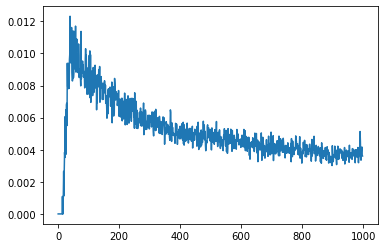

In [71]:
rhoPerDistChr1 = [ find_max_like_single_dist([dist,testChr1[dist-1] ]) for dist in range(1,1000)]
plt.plot(rhoPerDistChr1)

In [98]:
find_max_like_single_chr([testChr1,1])

[0.0023791458914622127, 0.0037951372198253806, 162.54363880206313]

In [86]:
find_max_like_single_chr([testChr1,100])

[0.00267441956729298, 0.004452934814619944, 112.96623364491461]

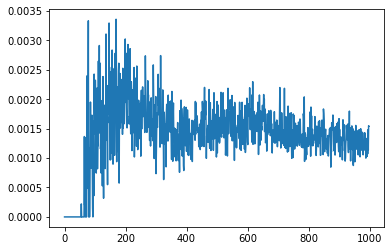

In [78]:
rhoPerDistChrX = [ find_max_like_single_dist([dist,testChrX[dist-1] ]) for dist in range(1,1000)]
plt.plot(rhoPerDistChrX)

In [ ]:
find_max_like_single_chr([testChrX,0])

In [95]:
minDistEffectX = [[dist,find_max_like_single_chr([testChrX,dist-1])] for dist in range(1,10)]

In [93]:
minDistEffectX

[[0.0011170507743139583, 0.0014404443802293167, 69.14312284678763],
 [0.0014422608308613115, 1e-07, 10.0],
 [0.001442372496066155, 1e-07, 10.0],
 [0.0014424615763307662, 1e-07, 10.0],
 [0.0014425504017009008, 1e-07, 10.0],
 [0.0014427129495557503, 1e-07, 10.0],
 [0.0014428287213405608, 1e-07, 10.0],
 [0.0014430080074073334, 1e-07, 10.0],
 [0.001443154839671209, 1e-07, 10.0],
 [0.0014433679619913968, 1e-07, 10.0]]

In [107]:
jobs = [[testChrX,dist] for dist in range(1,800,1)]
with Pool(cpu_count()) as p:
    thisRes = p.map(find_max_like_single_chr,jobs)

In [108]:
kappas = [a for [a,b,c] in thisRes]
gammas = [b for [a,b,c] in thisRes]
tractLength = [c for [a,b,c] in thisRes]

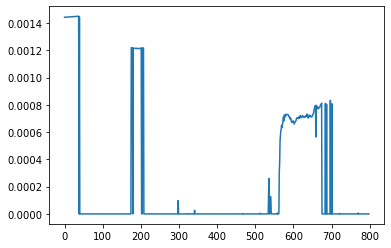

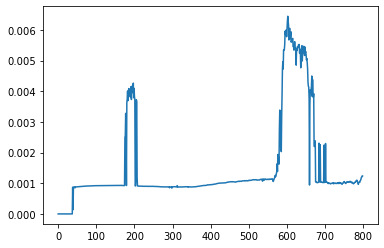

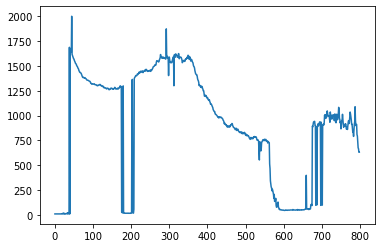

In [109]:
plt.plot(kappas)
plt.show()

plt.plot(gammas)
plt.show()

plt.plot(tractLength)
plt.show()

In [110]:
thisRes[250]

[1e-07, 0.0008975550983727526, 1458.6833133656755]

In [89]:
find_max_like_single_chr([testChrX,0])

[0.0014422608308613115, 1e-07, 10.0]

In [80]:
find_max_like_single_chr(testChrX,0])

[0.001442372496066155, 1e-07, 10.0]

In [200]:
def find_max_like_L_given_single_chr(args):
    inList,minDist = args
    lowerBounds = [ 1e-7, 1e-7,108]
    upperBounds = [ .05, .5, 108]
    startPoints = [ 0.000011, 0.000011, 108]

    opt=nlopt.opt(nlopt.LN_NELDERMEAD,3)

    opt.set_lower_bounds(lowerBounds)
    opt.set_upper_bounds(upperBounds)
    opt.set_max_objective(lambda x,grad: single_chr_obj_fun(x,inList[minDist-1:]))
    res = opt.optimize(startPoints)
    return([x for x in res])

In [207]:
jobs = [[testChrX,dist] for dist in range(1,500,5)]
with Pool(cpu_count()) as p:
    thisRes = p.map(find_max_like_L_given_single_chr,jobs)

In [208]:
kappasLgiven = [a for [a,b,c] in thisRes]
gammasLgiven = [b for [a,b,c] in thisRes]
tractLengthLgiven = [c for [a,b,c] in thisRes]

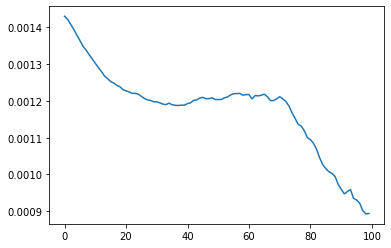

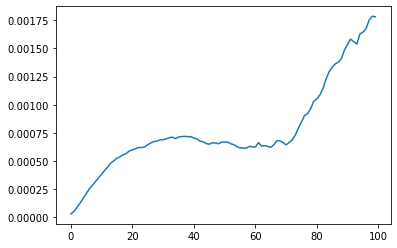

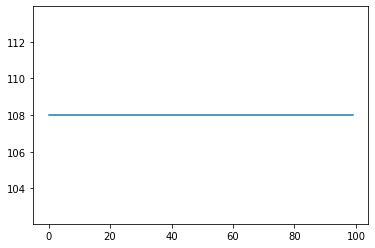

In [209]:
plt.plot(kappasLgiven)
plt.show()

plt.plot(gammasLgiven)
plt.show()

plt.plot(tractLengthLgiven)
plt.show()

In [201]:
find_max_like_L_given_single_chr([testChrX,1])

[0.001430355027504754, 3.0186082227798923e-05, 108.0]

In [202]:
find_max_like_L_given_single_chr([testChrX,100])


[0.0012282586136794951, 0.00059731697696097, 108.0]

In [203]:
find_max_like_L_given_single_chr([testChrX,250])

[0.0012029283708927482, 0.0006715248584783816, 108.0]

In [197]:
find_max_like_L_given_single_chr([testChr1,1])

[0.0028265223205573295, 0.004241856646641292, 108.0]

In [198]:
find_max_like_L_given_single_chr([testChr1,100])


[0.00270696766255915, 0.00455262421453804, 108.0]

In [199]:
find_max_like_L_given_single_chr([testChr1,250])

[0.0027038254982276293, 0.0045639763994895916, 108.0]